# Medical Image Segmentation with UNet++ and Datamint

This notebook demonstrates how to build an end-to-end **semantic segmentation** pipeline using **Datamint** and the **BUSI** (Breast Ultrasound Images) dataset with a **UNet++** architecture.

## Overview

You will learn how to:
- **Set up a Datamint project** for managing medical imaging data
- **Upload ultrasound images and segmentation masks** to Datamint
- **Build a custom PyTorch Dataset** that integrates with Datamint
- **Implement UNet++ with combined loss functions** (CrossEntropy + Dice)
- **Train the model** using PyTorch Lightning with MLflow tracking
- **Deploy the model** for inference using Datamint's model serving

## Table of Contents

1. [Setup: Create Project and Initialize API](#1-setup-create-project-and-initialize-api)
2. [Dataset Preparation: Download and Upload BUSI](#2-dataset-preparation-download-and-upload-busi)
3. [Custom PyTorch Dataset](#3-custom-pytorch-dataset)
4. [Model Architecture: UNet++ with Combined Loss](#4-model-architecture-unet-with-combined-loss)
5. [Training with MLflow Integration](#5-training-with-mlflow-integration)
6. [Visualization and Evaluation](#6-visualization-and-evaluation)
7. [Model Deployment](#7-model-deployment)

## Required Dependencies

```bash
pip install datamint segmentation-models-pytorch albumentations
```

## Dataset Overview

The **BUSI** (Breast Ultrasound Images) dataset contains ultrasound images of breast cancer with corresponding segmentation masks.
Three classes: benign, malignant, and normal tissues.

Dataset reference:
> Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief. 2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863.

In [1]:
from datamint import Api
from datamint.mlflow import set_project

PROJECT_NAME = "UNetPP_Segmentation_Tutorial"
api = Api()

## 1. Setup: Create Project and Initialize API

In this section, we will:
- Create a new Datamint project (or retrieve an existing one)
- Set up the MLflow project context for experiment tracking

In [2]:
proj = api.projects.get_by_name(PROJECT_NAME)
if proj is None:
    print(f"Creating project '{PROJECT_NAME}'")
    proj = api.projects.create(
        name=PROJECT_NAME,
        description="Tutorial project for UNet++ segmentation on BUSI dataset"
    )
else:
    print(f"Using existing project '{PROJECT_NAME}'")

set_project(PROJECT_NAME)  # Important for proper experiment tracking

Using existing project 'UNetPP_Segmentation_Tutorial'


Project(id='1a963aa0-7c4a-4b2a-924a-0a442a389d03', name='UNetPP_Segmentation_Tutorial', created_at='2026-01-21T17:03:38.072Z', created_by='lucasmello.research@gmail.com', dataset_id='72d6bbea-db72-433e-b518-f4fdb876529a', worklist_id='14bf9a1b-42bd-47f5-819f-17b0f6806212', archived=False, resource_count=780, annotated_resource_count=0, description='Tutorial project for UNet++ segmentation on BUSI dataset', viewable_ai_segs=None, editable_ai_segs=None, closed_resources_count=0, resources_to_annotate_count=0, most_recent_experiment=None, annotators=[{'email': 'lucasmello.research@gmail.com', 'roles': ['PROJECT_OWNER'], 'status': 'active'}])

## 2. Dataset Preparation: Download and Upload BUSI

In this section, we will:
- Download the BUSI dataset
- Upload ultrasound images to Datamint
- Upload corresponding segmentation masks
- Create train/val/test splits

### 2.1 Download BUSI Dataset

The BUSI dataset is available from Kaggle. For this tutorial, we'll use the breast ultrasound images dataset.

> Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief. 2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863.

In [ ]:
import os
import requests
import zipfile
from pathlib import Path

BUSI_URL = "https://www.kaggle.com/api/v1/datasets/download/sabahesaraki/breast-ultrasound-images-dataset"
DATA_DIR = Path("/tmp/BUSI_dataset") # Change this path as needed

if not DATA_DIR.exists():
    print("Downloading BUSI dataset...")

    # Download the dataset
    response = requests.get(BUSI_URL, stream=True)
    response.raise_for_status()
    zip_path = DATA_DIR / "Dataset_BUSI.zip"

    DATA_DIR.mkdir(parents=True, exist_ok=True)
    with open(zip_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print("Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)

    os.remove(zip_path)
    print("Download complete!")
else:
    print(f"Dataset already exists at {DATA_DIR}")

### 2.2 Explore Dataset Structure

The BUSI dataset contains folders for each class:
- **benign**: Images and masks for benign cases
- **malignant**: Images and masks for malignant cases
- **normal**: Images and masks for normal cases

```
Dataset_BUSI/
├── benign/
│   ├── benign (1).png
│   ├── benign (1)_mask.png
│   └── ...
├── malignant/
│   └── ...
└── normal/
    └── ...
```

In [3]:
# Find image and label paths
base_dir = DATA_DIR / "Dataset_BUSI_with_GT"
classes = ["benign", "malignant", "normal"]

image_paths = []
label_paths = []

for cls in classes:
    cls_dir = base_dir / cls
    # Images are files that don't contain "_mask"
    cls_images = sorted([p for p in cls_dir.glob("*.png") if "_mask" not in p.name])
    for img_p in cls_images:
        # Find corresponding mask (taking the first one if multiple exist)
        mask_p = cls_dir / f"{img_p.stem}_mask.png"
        if mask_p.exists():
            image_paths.append(img_p)
            label_paths.append(mask_p)

print(f"Found {len(image_paths)} ultrasound images")
print(f"Found {len(label_paths)} segmentation masks")

NameError: name 'DATA_DIR' is not defined

### 2.3 Define Classes

We map class ids to class names for segmentation.
We need this mapping because training labels are stored as integers (not strings) in the masks.


In [4]:
# Class mapping for segmentation. 
# Class 0 is background (no tumor)
CLASS_NAMES = {
    0: "background",
    1: "benign",
    2: "malignant",
}

CLASS_NAME_TO_LABEL = {v: k for k, v in CLASS_NAMES.items()}
NUM_CLASSES = len(CLASS_NAMES)

print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 3


### 2.4 Upload Images to Datamint

We upload each ultrasound image as a resource with appropriate tags.

In [ ]:
# Upload images to Datamint
uploaded_resources = api.resources.upload_resources(
    [str(p) for p in image_paths],
    tags=['busi', 'ultrasound', 'breast'],
    publish_to=proj,
    progress_bar=True
)

print(f"Uploaded {len(uploaded_resources)} images to Datamint")

### 2.5 Upload Segmentation Masks

Now we upload the corresponding segmentation masks.

In [ ]:
from tqdm.auto import tqdm

# Get resources from project
all_resources = list(api.resources.get_list(project_name=PROJECT_NAME, tags=['busi']))
filename_to_resource = {r.filename: r for r in all_resources}

# Upload segmentation masks
for img_path, label_path in tqdm(zip(image_paths, label_paths), total=len(image_paths)):
    if 'normal' in img_path.parent.name:
        # Skip normal images (no lesions)
        continue
    resource = filename_to_resource[img_path.name]
    
    # Determine class from file path. Example ``img_path``: 'Dataset_BUSI_with_GT/benign/BUSI_123.png'
    cls_name = img_path.parent.name # 'benign' or 'malignant'
    
    api.annotations.upload_segmentations(
        resource=resource,
        file_path=label_path,
        name=cls_name,
        imported_from="Original GT BUSI Dataset", # source of the masks. Arbitrary string
    )

print("Segmentation masks uploaded successfully!")

In [5]:
# Verify uploads - inspect a sample resource
sample_resource = api.resources.get_list(project_name=PROJECT_NAME, limit=1)[0]
sample_annotations = api.annotations.get_list(resource=sample_resource, annotation_type='segmentation')

print(f"Resource: {sample_resource.filename}")
print(f"  Number of segmentation annotations: {len(sample_annotations)}")
if sample_annotations:
    print(f"  First annotation: {sample_annotations[0].asdict()}")

Resource: normal (130).png
  Number of segmentation annotations: 0


### 2.6 Create Train/Validation/Test Splits

We split the dataset into three subsets using tags for reproducibility.

| Split | Percentage | Purpose |
|-------|------------|---------|
| Train | 70% | Model training |
| Validation | 15% | Hyperparameter tuning, early stopping |
| Test | 15% | Final model evaluation |

In [5]:
import random

# Get all resources
all_resources = list(api.resources.get_list(project_name=PROJECT_NAME, tags=['busi']))
all_resources.sort(key=lambda r: r.filename)

# Shuffle with fixed seed
random.seed(42)
random.shuffle(all_resources)

# Split ratios
n_total = len(all_resources)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val

train_resources = all_resources[:n_train]
val_resources = all_resources[n_train:n_train + n_val]
test_resources = all_resources[n_train + n_val:]

print(f"Total resources: {n_total}")
print(f"Training: {len(train_resources)}")
print(f"Validation: {len(val_resources)}")
print(f"Test: {len(test_resources)}")

Total resources: 780
Training: 546
Validation: 117
Test: 117


In [ ]:
# Apply split tags to resources
api.resources.add_tags(train_resources, ['split:train'])
api.resources.add_tags(val_resources, ['split:val'])
api.resources.add_tags(test_resources, ['split:test'])

## 3. Custom PyTorch Dataset

In this section, we'll build a PyTorch Dataset that:
- Fetches images and segmentation masks from Datamint
- Applies normalization
- Uses Albumentations for data augmentation

### 3.1 Define Data Transforms

We use [Albumentations](https://albumentations.ai/) for image and mask augmentation. The key is that augmentations are applied **consistently** to both image and mask.

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Image size for UNet++ (should be divisible by 32 for encoder-decoder architectures)
IMAGE_SIZE = 256

# Training transforms with augmentation
train_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ElasticTransform(alpha=50, sigma=5, p=0.3),
    A.GridDistortion(num_steps=5, distort_limit=0.2, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.Normalize(0,1),  # Normalize to [0, 1] by dividing by 255
    ToTensorV2(),
])

# Validation/Test transforms (no augmentation)
val_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(0,1), # Normalize to [0, 1] by dividing by 255
    ToTensorV2(),
])

### 3.2 Implement Custom PyTorch Dataset

The `MedicalSegmentationDataset` class handles:
- Loading images from Datamint
- Applying preprocessing and augmentation
- Returning image-mask pairs for training

In [7]:
import torch
from torch.utils.data import Dataset
from collections import defaultdict
import numpy as np

class MedicalSegmentationDataset(Dataset[dict]): # dataset that returns dicts
    def __init__(
        self,
        split: str | None = None,
        transforms =  None,
    ):
        """
        Medical Segmentation Dataset for BUSI dataset stored in Datamint.

        Args:
            split (str | None): One of 'train', 'val', 'test', or None for all data.
            transforms: Albumentations transforms to apply.
            resources (list[Resource] | None): Optional pre-fetched list of resources. If None, fetches from Datamint based on split.
            inference_mode (bool): If True, dataset is used for inference (no masks).
        """
        self.transforms = transforms
        self.num_classes = NUM_CLASSES
        
        self.resources = api.resources.get_list(
            project_name=PROJECT_NAME,
            tags=[f'split:{split}'] if split else None,
        )
            
        all_annotations = api.annotations.get_list(
            resource=self.resources,
            annotation_type='segmentation'
        )
    
        self.resource_annotations = defaultdict(list) # just mapping resource_id -> [annotations]
        for ann in all_annotations:
            self.resource_annotations[ann.resource_id].append(ann)
        
    def __len__(self):
        return len(self.resources)
    
    def __getitem__(self, idx:int) -> dict:
        resource = self.resources[idx]
        
        # Load image
        image = resource.fetch_file_data(auto_convert=True, use_cache=True)
        original_width = image.width
        original_height = image.height
        # image is a PIL.Image object
        image = np.array(image) # image.shape: (H, W, 3) or (H, W)
        
        # Convert grayscale to RGB if needed
        if image.ndim == 2:
            image = np.stack([image] * 3, axis=-1)
        
        # Load mask if not in inference mode
        annotations = self.resource_annotations[resource.id]
        if not annotations or 'normal' in resource.filename:
            mask = np.zeros((original_height, original_width), dtype=np.int64)
        else:
            if len(annotations) > 1:
                print(f"Warning: Resource {resource.filename} has multiple annotations. Using the first one.")
            mask = np.array(annotations[0].fetch_file_data(use_cache=True)).astype(np.int64)
            # Convert binary mask {0, 255} to class indices {0, 1 or 2}
            # Determine class from filename
            if 'benign' in resource.filename:
                mask = (mask > 0).astype(np.int64)  # 0 -> 0 (background), 255 -> 1 (benign)
            elif 'malignant' in resource.filename:
                mask = (mask > 0).astype(np.int64) * 2  # 0 -> 0 (background), 255 -> 2 (malignant)
        
        if self.transforms:
            if mask is not None:
                transformed = self.transforms(image=image, mask=mask)
                image = transformed['image']
                mask = transformed['mask'].long()
            else:
                transformed = self.transforms(image=image)
                image = transformed['image']
        else:
            # Fallback if no transforms provided
            image = torch.from_numpy(image).float() / 255.0
            if image.ndim == 2:
                image = image.unsqueeze(0)
            if mask is not None:
                mask = torch.from_numpy(mask).long()
        
        res = {
            "image": image, 
            "mask": mask,
            "filename": resource.filename,
            'original_width': original_width,
            'original_height': original_height
        }

        return res

In [8]:
# Test Dataset

train_dataset = MedicalSegmentationDataset(
    split='train',
    transforms=train_transforms,
)

train_dataset[0].keys()  # Fetch first sample to test

dict_keys(['image', 'mask', 'filename', 'original_width', 'original_height'])

### 3.4 Create DataLoaders

Now we instantiate datasets and dataloaders for each split.

In [9]:
from torch.utils.data import DataLoader

# Configuration
BATCH_SIZE = 16 # Adjust based on your GPU memory
NUM_WORKERS = 4  # Adjust based on your CPU cores


# Create datasets
print("Building training dataset...")
train_dataset = MedicalSegmentationDataset(
    split='train',
    transforms=train_transforms,
)
print(f"  Training samples (slices): {len(train_dataset)}")

print("Building validation dataset...")
val_dataset = MedicalSegmentationDataset(
    split='val',
    transforms=val_transforms,
)
print(f"  Validation samples (slices): {len(val_dataset)}")

print("Building test dataset...")
test_dataset = MedicalSegmentationDataset(
    split='test',
    transforms=val_transforms,
)
print(f"  Test samples (slices): {len(test_dataset)}")

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

Building training dataset...
  Training samples (slices): 546
Building validation dataset...
  Validation samples (slices): 117
Building test dataset...
  Test samples (slices): 117


Batch image shape: torch.Size([16, 3, 256, 256])
Batch mask shape: torch.Size([16, 256, 256])
Filename: benign (62).png
Filename: benign (386).png


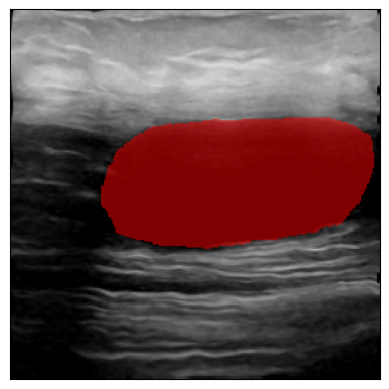

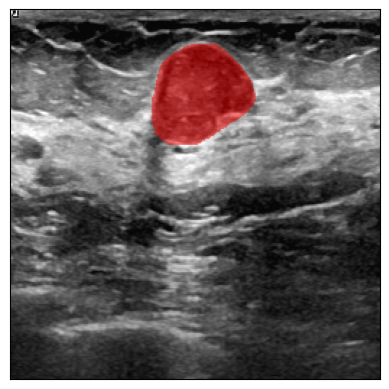

In [10]:
# Visualize a sample batch
from datamint.utils.visualization import show, draw_masks


sample_batch = next(iter(train_dataloader))
print(f"Batch image shape: {sample_batch['image'].shape}")  # (B, C, H, W)
print(f"Batch mask shape: {sample_batch['mask'].shape}")    # (B, H, W)

# Plot first 2 samples
for i in range(2):
    img = sample_batch['image'][i]
    mask = sample_batch['mask'][i]
    print(f"Filename: {sample_batch['filename'][i]}")
    img_with_mask = draw_masks(img, mask)
    show(img_with_mask)

## 4. Model Architecture: UNet++ with Combined Loss

In this section, we'll implement:
- **UNet++** architecture using `segmentation_models_pytorch`
- **Dice Loss** for handling class imbalance
- **Combined Loss** (CrossEntropy + Dice) for better segmentation
- **Lightning Module** for training

### 4.1 UNet++ Architecture

UNet++ is an improved version of U-Net with nested dense skip connections. This architecture enhances feature propagation and reduces the semantic gap between the encoder and decoder.

### 4.2 Custom Loss Functions

For semantic segmentation, we use a combination of:
- **CrossEntropyLoss**: Standard classification loss per pixel
- **Dice Loss**: Optimizes the Dice coefficient directly, handles class imbalance better

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.segmentation import DiceScore

class CombinedLoss(nn.Module):
    """Combined CrossEntropy and Dice Loss.
    
    This combination provides:
    - CrossEntropy: Pixel-level classification accuracy
    - Dice: Global overlap optimization, handles class imbalance
    
    Args:
        num_classes: Number of segmentation classes
        ce_weight: Weight for CrossEntropy loss
        dice_weight: Weight for Dice loss
    """
    
    def __init__(
        self,
        num_classes: int,
        ce_weight: float = 1.0,
        dice_weight: float = 1.0,
        class_weights: torch.Tensor | None = None,
    ):
        super().__init__()
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
        self.dicescore = DiceScore(num_classes=num_classes, 
                                   average='macro',
                                   input_format="mixed")
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
    
    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Args:
            pred: Predictions (B, C, H, W) - logits
            target: Ground truth (B, H, W) - class indices
            
        Returns:
            Combined loss (scalar)
        """
        ce = self.ce_loss(pred, target.long())
        dice = 1 - self.dicescore(F.softmax(pred, dim=1), target)
        
        return self.ce_weight * ce + self.dice_weight * dice


# Quick test
dummy_pred = torch.randn(2, NUM_CLASSES+1, 64, 64) # logits
dummy_target = torch.randint(0, NUM_CLASSES+1, (2, 64, 64))

loss_fn = CombinedLoss(num_classes=NUM_CLASSES+1)
loss = loss_fn(dummy_pred, dummy_target)
print(f"Test loss value: {loss.item():.4f}")

Test loss value: 2.4718


### 4.3 UNet++ Lightning Module

We wrap UNet++ in a PyTorch Lightning module for clean training code.

In [12]:
import segmentation_models_pytorch as smp
import lightning as L
from torchmetrics.segmentation import MeanIoU, GeneralizedDiceScore


class UNetPPModule(L.LightningModule):
    """PyTorch Lightning module for UNet++ segmentation.
    
    This module handles:
    - Model architecture (UNet++ with pretrained encoder)
    - Combined loss function (CrossEntropy + Dice)
    - Metrics tracking (IoU, Dice)
    - Optimizer configuration with learning rate scheduling
    
    Args:
        num_classes: Number of segmentation classes (including background)
        encoder_name: Name of the encoder backbone (e.g., 'resnet34', 'efficientnet-b0')
        learning_rate: Initial learning rate
    """
    
    def __init__(
        self,
        num_classes: int,
        encoder_name: str = 'resnet34',
        learning_rate: float = 1e-4,
    ):
        super().__init__()
        self.save_hyperparameters() # Save hyperparameters for logging

        self.learning_rate = learning_rate
        
        # UNet++ model from segmentation_models_pytorch
        self.model = smp.UnetPlusPlus(
            encoder_name=encoder_name,
            encoder_weights='imagenet',
            in_channels=3,  # RGB input (we repeat grayscale to 3 channels)
            classes=num_classes,
        )
        
        # Loss function
        self.criterion = CombinedLoss(
            num_classes=num_classes,
            ce_weight=1.0,
            dice_weight=1.0,
        )

        # Metrics for each split
        # Note: MeanIoU expects predictions and targets as one-hot encoded by default.
        #   Therefore, we need to change expected input_format.
        self.iou_metrics = {
            'train': MeanIoU(num_classes=num_classes, input_format='index'),
            'val': MeanIoU(num_classes=num_classes, input_format='index'),
            'test': MeanIoU(num_classes=num_classes, input_format='index'),
        }
        # register the iou metrics:
        for stage, metric in self.iou_metrics.items():
            self.add_module(f"{stage}_mean_iou", metric)

        self.dice_metrics = {
            'train': GeneralizedDiceScore(num_classes=num_classes, input_format='index'),
            'val': GeneralizedDiceScore(num_classes=num_classes, input_format='index'),
            'test': GeneralizedDiceScore(num_classes=num_classes, input_format='index'),
        }
        # register the dice metrics:
        for stage, metric in self.dice_metrics.items():
            self.add_module(f"{stage}_dice_score", metric)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through UNet++."""
        return self.model(x)
    
    def _common_step(self, batch: dict, stage: str) -> torch.Tensor:
        """Common step for train/val/test.
        
        Args:
            batch: Dictionary with 'image' and 'mask' tensors
            stage: One of 'train', 'val', 'test'
            
        Returns:
            Loss tensor
        """
        images = batch['image']
        masks = batch['mask'] # input format: index-based. shape: (B, H, W)
        
        # Forward pass
        logits = self(images)  # (B, C, H, W)
        
        # Compute loss
        loss = self.criterion(logits, masks)
        
        # Get predictions (class indices)
        preds = torch.argmax(logits, dim=1)  # (B, H, W)
        
        # Update metrics
        if stage is not None:
            self.iou_metrics[stage].update(preds, masks)
            self.dice_metrics[stage].update(preds, masks)
            self.log(f'{stage}/loss', loss, on_step=(stage == 'train'), on_epoch=True, prog_bar=True, batch_size=len(images))
        
        return loss
    
    def training_step(self, batch: dict, batch_idx: int) -> torch.Tensor:
        return self._common_step(batch, 'train')
    
    def validation_step(self, batch: dict, batch_idx: int) -> torch.Tensor:
        return self._common_step(batch, 'val')
    
    def test_step(self, batch: dict, batch_idx: int) -> torch.Tensor:
        return self._common_step(batch, 'test')
    
    def predict_step(self, batch: dict, batch_idx: int) -> torch.Tensor:
        images = batch['image']
        logits = self(images)
        preds = torch.argmax(logits, dim=1)
        return preds
    
    def _common_epoch_end(self, stage: str):
        iou = self.iou_metrics[stage]
        dice = self.dice_metrics[stage]
        self.log(f'{stage}/iou', iou.compute(), prog_bar=True)
        self.log(f'{stage}/dice', dice.compute())
        iou.reset()
        dice.reset()
    
    def on_train_epoch_end(self):
        self._common_epoch_end('train')
    
    def on_validation_epoch_end(self):
        self._common_epoch_end('val')

    def on_test_epoch_end(self):
        self._common_epoch_end('test')
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=1e-4,
        )
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=5,
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val/loss',
                'interval': 'epoch',
            }
        }

In [13]:
# Instantiate the model
model = UNetPPModule(
    num_classes=NUM_CLASSES,
    encoder_name='resnet34',  # Lightweight encoder for faster training
    learning_rate=1e-4,
)

# Test forward pass
with torch.inference_mode():
    sample_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE)
    sample_output = model(sample_input)
    print(f"Output shape: {sample_output.shape}")

    # test loss computation
    sample_target = train_dataloader.dataset[-1]['mask']  # (1, H, W)
    sample_loss = model.criterion(sample_output, sample_target.unsqueeze(0))
    print(f"Sample loss: {sample_loss.item():.4f}")

Output shape: torch.Size([1, 3, 256, 256])
Sample loss: 2.6595


## 5. Training with MLflow Integration

In this section, we'll:
- Configure MLflow for experiment tracking
- Set up model checkpointing with automatic registration
- Train the model with early stopping
- Monitor progress via Datamint dashboard

In [ ]:
from datamint.mlflow.lightning.callbacks import MLFlowModelCheckpoint
from lightning.pytorch.loggers import MLFlowLogger
from lightning.pytorch.callbacks import EarlyStopping

# Ensure project context is set
set_project(PROJECT_NAME)

# MLflow checkpoint callback
# This callback automatically:
# - Saves the best model based on validation IoU
# - Registers the model in MLflow Model Registry after testing
checkpoint_callback = MLFlowModelCheckpoint(
    monitor="val/iou",                    # Metric to monitor
    mode="max",                           # Save when metric increases
    save_top_k=1,                         # Keep only the best model
    filename="best_unetpp",               # Checkpoint filename
    save_weights_only=True,              # Save full model state
    register_model_name=PROJECT_NAME,     # Name in Model Registry
    register_model_on='test',             # Register after test evaluation
)

# Early stopping callback
early_stop_callback = EarlyStopping(
    monitor="val/iou",
    mode="max",
    patience=10                          # Stop if no improvement for 10 epochs
)

# MLflow logger for experiment tracking
mlflow_logger = MLFlowLogger(
    experiment_name=f"{PROJECT_NAME}_training",
    run_name="unetpp_resnet34_busi_metrics_fixed",
)

print("Training callbacks configured!")

>>> Initializing MLFlowLogger with tracking_uri=http://api.datamint.io:5000, save_dir=./mlruns
Training callbacks configured!


### 5.1 Start Training

We use PyTorch Lightning's Trainer for clean, scalable training.

In [ ]:
# Initialize trainer
trainer = L.Trainer(
    max_epochs=20,                        # Maximum training epochs
    logger=mlflow_logger,                 # MLflow logging
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator='auto',                   # Auto-detect GPU/CPU
    # precision='16-mixed',                 # Mixed precision for faster training, if supported
)

# Start training
print("🚀 Starting training...")
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

### 5.2 Monitor Training Progress

While training runs, you can monitor progress in two ways:
1. **Terminal output**: Loss and metrics per epoch
2. **Datamint Dashboard**: Visual experiment tracking

Run `proj.show()` to open the project dashboard in your browser.

In [ ]:
# Open the Datamint project dashboard
proj.show()

### 5.3 Evaluate on Test Set

After training, evaluate the model on the test set to get final metrics.
This also triggers model registration in MLflow (due to `register_model_on='test'`).

In [ ]:
# Evaluate on test set and register model
print("🔍 Evaluating on test set...")
test_results = trainer.test(dataloaders=test_dataloader)

print(f"Best model checkpoint: {checkpoint_callback.best_model_path}")
print(f"Best validation IoU: {checkpoint_callback.best_model_score:.4f}")

## 6. Visualization and Evaluation

In this section, we'll:
- Visualize predictions vs ground truth
- Create overlay visualizations
- Analyze per-class performance

### 6.1 Visualize Predictions

Let's visualize model predictions on the test set.

In [ ]:
def visualize_predictions(model, dataset):
    """Visualize model predictions compared to ground truth.
    
    Args:
        model: Trained model
        dataset: Dataset to sample from
        indices: Specific indices to visualize (optional)
        device: Device for inference
    """
    model.eval()
    
    idx = np.random.choice(len(dataset), 1, replace=False)[0]
    
    with torch.inference_mode():
        sample = dataset[idx]
        image = sample['image'].unsqueeze(0).to(model.device)
        mask_gt = sample['mask'] # shape: (H, W)
        
        logits = model(image) # shape: (1, #classes, H, W)
        mask_pred = torch.argmax(logits, dim=1).squeeze(0).cpu() # shape: (H, W)

        overlay_mask = draw_masks(image.squeeze(0).cpu(), torch.stack([mask_gt, mask_pred]), alpha=0.5)
        show(overlay_mask)

        yp = (mask_pred == 1).sum().item() # predicted positives
        yg = (mask_gt == 1).sum().item() # ground truth positives
        tp = ((mask_pred == 1) & (mask_gt == 1)).sum().item() # true positives
        iou = tp / (yp + yg - tp) if (yp + yg - tp) > 0 else 1.0
        print(f"IoU: {iou:.1%}")

visualize_predictions(model, test_dataset)

## 7. Model Deployment

For production use, we wrap our model in a **Datamint Model Adapter**. This adapter:
- Standardizes input/output format
- Handles resource loading from Datamint
- Enables deployment via MLflow Model Serving or Datamint's inference API
- Returns structured `ImageSegmentation` annotations

### 7.1 Create Datamint Model Adapter

The `DatamintModel` base class provides a consistent interface for model deployment.

In [ ]:
from datamint.mlflow.flavors.model import DatamintModel
from datamint.entities.annotations import ImageSegmentation
from datamint.entities import Resource
import torch
import cv2
import numpy as np
from typing_extensions import override

class UNetPPSegmentationAdapter(DatamintModel):
    """Datamint adapter for UNet++ segmentation model deployment."""
    
    def __init__(self):
        super().__init__(
            mlflow_torch_models_uri={
                'unetpp': f'models:/{PROJECT_NAME}/latest' # URI in MLflow Model Registry. An efficient way to link your new model to this one
            }, 
            settings={'need_gpu': True}
        )
        self.class_names = CLASS_NAMES
    
    @override
    def predict_image(self, model_input: list[Resource], **kwargs):
        pytorch_model = self.get_mlflow_torch_models()['unetpp']
        pytorch_model.eval()
        
        # Use Lightning Fabric for device management, instead of L.Trainer. Lightweight and perfect for inference.
        fabric = L.Fabric(accelerator=self.inference_device)
        pytorch_model = fabric.setup_module(pytorch_model)

        all_predictions = []
        with torch.inference_mode():
            for res in model_input:
                image = res.fetch_file_data(auto_convert=True, use_cache=True)
                # image is a PIL.Image object
                original_width = image.width
                original_height = image.height

                image = np.array(image)
                image_tensor = val_transforms(image=image)['image'].to(fabric.device)  # (3, H, W)
                logits = pytorch_model(image_tensor.unsqueeze(0)) # unsqueeze to (1, 3, H, W)
                pred = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

                # Implement here any post-processing if desired
                # reshape prediction to original size
                pred = cv2.resize(pred.astype(np.uint8), 
                                  (original_width, original_height), 
                                  interpolation=cv2.INTER_NEAREST)
                annotations = []
                for class_idx, class_name in self.class_names.items():
                    if class_idx == 0:  # Skip background class
                        continue
                    class_mask = (pred == class_idx).astype(np.uint8) * 255  # Convert to {0, 255} for visualization
                    if class_mask.any(): # at least one pixel
                        pred_ann = ImageSegmentation(name=class_name, mask=class_mask)
                        annotations.append(pred_ann)
                all_predictions.append(annotations)        

        return all_predictions

adapter = UNetPPSegmentationAdapter()

### 7.2 Log the Adapter to MLflow

We log the adapter model to MLflow, making it available for deployment.

In [ ]:
from datamint.mlflow.flavors import datamint_flavor
from mlflow import set_experiment
import mlflow
from datamint.mlflow import set_project

# Set project and experiment context
set_project(PROJECT_NAME)
set_experiment(f'{PROJECT_NAME}_deployment') # Arbitrary experiment name. Create or use an existing one.

adapter = UNetPPSegmentationAdapter()

# Log the adapter to MLflow
ADAPTED_MODEL_NAME = f"{PROJECT_NAME}_adapted"

with mlflow.start_run(run_name="unetpp_segmentation_adapter"): # Create a new MLflow run. You can use an existing one as well
    model_info = datamint_flavor.log_model(
        adapter,
        registered_model_name=ADAPTED_MODEL_NAME,
    )

print(f"✅ Adapter logged successfully!")
print(f"Model URI: {model_info.model_uri}")

### 7.3 Test Local Inference

Before deploying, verify the adapter works correctly with local inference.

In [ ]:
import mlflow

# Load the registered adapter model
loaded_model = mlflow.pyfunc.load_model(f'models:/{ADAPTED_MODEL_NAME}/latest')

# Test with a resource from the test set
test_resource = test_dataset.resources[-1]
print(f"Testing with: {test_resource.filename}")

# Run prediction
predictions = loaded_model.predict([test_resource])

print(f"\n✅ Prediction successful!")
print(f"Number of annotations: {len(predictions[0])}")
for ann in predictions[0]:
    n_pixels = (ann.mask > 0).sum()
    print(f"  - {ann.name}: {n_pixels} pixels ({n_pixels / (ann.mask.size) :.1%} of the image)")

print('Ground truth:')
gt_annotations = api.annotations.get_list(
    resource=test_resource,
    annotation_type='segmentation'
)
for ann in gt_annotations:
    mask = np.array(ann.fetch_file_data(use_cache=True))
    n_pixels = (mask > 0).sum()
    print(f"  - {ann.name}: {n_pixels} pixels ({n_pixels / (mask.size) :.1%} of the image)")

### 7.4 Deploy to Datamint Server

Start a deployment job to serve the model via Datamint's inference API.

In [ ]:
# Start deployment job
job = api.deploy.start(
    model_name=ADAPTED_MODEL_NAME,
    model_alias="latest",
    with_gpu=True,  # Use GPU for inference
)

print(f"🚀 Deployment job started!")
print(f"Job ID: {job.id}")
print(f"Status: {job.status}")
print(f"Model: {job.model_name}")

In [ ]:
# Check deployment status
job = api.deploy.get_by_id(job.id)

print(f"Job Status: {job.status}")
print(f"Progress: {job.progress_percentage}%")

if job.error_message:
    print(f"Error: {job.error_message}")

## 8. Summary

Congratulations! 🎉 You've completed the UNet++ Segmentation Tutorial with the BUSI dataset.

### What You Learned

| Step | Description |
|------|-------------|
| **Data Management** | Uploaded ultrasound images and masks to Datamint |
| **Custom Dataset** | Built a PyTorch Dataset for 2D ultrasound images |
| **Model Architecture** | Implemented UNet++ with combined CrossEntropy + Dice loss |
| **Training** | Trained with MLflow experiment tracking |
| **Deployment** | Built a DatamintModel adapter for production inference |

### References

- [Datamint Documentation](https://sonanceai.github.io/datamint-python-api/)
- [BUSI Dataset](https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset)
- [Segmentation Models PyTorch](https://github.com/qubvel/segmentation_models.pytorch)